# Setup

In [1]:
!pip install -q tf-models-official==2.3.0
!pip install transformers

In [2]:
import os
import json, pickle

import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import transformers
from transformers import BertTokenizer, TFBertModel
transformers.logging.set_verbosity_error() # suppress tokenizer sentences' length warnings
tf.get_logger().setLevel('ERROR')

from keras import Model
from keras.utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout, Activation
from datetime import datetime

from google.colab import drive, files

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Settings


In [4]:
### PARAMETERS ###
RANDOM_STATE = 42

# Dataset creation
SEQUENCE_LIMIT = 512
STRIDE = 256

SHUFFLE = True

TRAIN_LIMIT = None  # set None for the full size
VAL_LIMIT = None    # set None for the full size
TEST_LIMIT = None   # set None for the full size

# Model Training
EPOCHS = 1
BATCH_SIZE = 8

# dataset drive settings
SAVE_DATASET = False
LOAD_DATASET = True

# model weights drive settings
SAVE_WEIGHTS = False
LOAD_WEIGHTS = True

# training settings
TRAIN = False

# Dataset

In [5]:
try:
  with open('training_set.json') as f:
    json_data = json.load(f)
except:
  with open('/content/drive/My Drive/SQUAD/training_set.json') as f:
    json_data = json.load(f)

In [6]:
# Creates DataFrames with useful columns by unpacking 'paragraphs' column
def unpack_df(df):
  temp = []
  title_dict = {}
  contexts = []

  for i, row in df.iterrows():
    for context in row['paragraphs']:
      contexts.append(context['context'])
      for qa in context['qas']:
        question_id = qa['id']
        question = qa['question']
        for answer in qa['answers']:
          answer_text = answer['text']
          answer_start = answer['answer_start']
          answer_end = answer_start+len(answer_text)
          temp.append([question_id, question, answer_text, answer_start, answer_end, i, len(contexts)-1])

  context_dict = dict(enumerate(contexts))
  df = pd.DataFrame(temp, columns=['question_id', 'question_text', 'answer_text', 'answer_start', 'answer_end', 'title_id', 'context_id'])
  
  return df, context_dict

# Read data from json
data = pd.json_normalize(json_data['data'])

# Split train and test
train_val, test = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
train, val = train_test_split(train_val, test_size=0.25, random_state=RANDOM_STATE)

# Create DataFrames with useful columns
train_df, train_context_dict = unpack_df(train)
val_df, val_context_dict = unpack_df(val)
test_df, test_context_dict = unpack_df(test)

# Shuffle DataFrame
if SHUFFLE:
  train_df = train_df.sample(frac = 1, random_state=RANDOM_STATE)
  val_df = val_df.sample(frac = 1, random_state=RANDOM_STATE)
  test_df = test_df.sample(frac = 1, random_state=RANDOM_STATE)

train_df

,question_id,question_text,answer_text,answer_start,answer_end,title_id,context_id
21155,56e79cf000c9c71400d773b5,How many times have KU teams appeared in the N...,70,45,47,80,4716
44541,572955523f37b31900478275,What are egg tubes called?,ovarioles,207,216,325,9680
13242,57284b0c4b864d19001648db,"What was the first ""Special Edition"" film to b...",the 1984 Criterion Collection edition of Citiz...,180,233,315,2964
3035,5730f29da5e9cc1400cdbb2b,What was ceded to Namibia in 1994?,Walvis Bay,530,540,414,654
48343,572eeae6cb0c0d14000f166e,Who ruled most of India in the early 18th cent...,Mughal Empire,32,45,380,10519
...,...,...,...,...,...,...,...
11284,573095a62461fd1900a9cec5,What includes debris and nesting birds?,Hazards to aircraft,0,19,408,2532
44732,572e88edcb0c0d14000f126c,Who created the safety elevator in 1852?,Elisha Otis,9,20,364,9719
38158,572716f05951b619008f85b7,What was Immanuel Nobel son's name?,Alfred Nobel,276,288,252,8314
860,5727d99a3acd2414000dee10,When did the Tibetan government sign the Simla...,1914,672,676,300,188


In [7]:
# Inspect data samples
def print_squad_sample(train_data, context_dict, line_length=120, separator_length=150):

  sample = train_data.sample(frac=1).head(1)
  context = context_dict[sample['context_id'].item()]

  print('='*separator_length, '\nCONTEXT:\n', '='*separator_length)

  lines = [''.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
  for l in lines:
      print(l)

  print('='*separator_length, '\nQUESTION:', ' '*(3*separator_length//4), 'ANSWER:')

  questions = train_data[train_data['context_id'] == sample['context_id'].item()]

  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), answer)

print_squad_sample(train_df, train_context_dict)

CONTEXT:
Backup and Restore, the backup component of Windows, is deprecated. It still ships with Windows 8 and continues to work 
on preset schedules, but is pushed to the background and can only be accessed through a Control Panel applet called "Win
dows 7 File Recovery".:76 Shadow Copy, a component of Windows Explorer that once saved previous versions of changed file
s, no longer protects local files and folders. It can only access previous versions of shared files stored on a Windows 
Server computer.:74 The subsystem on which these components worked, however, is still available for other software to us
e.:74
QUESTION:                                                                                                                  ANSWER:
What is :74 used for?                                                                                                      other software
What backup element is still found on Windows 8?                                                               

## Tokenizer

In [8]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print('[[CLS], [SEP]] = {}'.format(tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])))

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(train_df['question_text'][0])

# Print out the tokens.
print('\nTokenized sentence:')
print(tokenized_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indices.
print('\n{:<12} {:>6}\n'.format('TOKENS', 'INDICES'))
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6}'.format(tup[0], tup[1]))

[[CLS], [SEP]] = [101, 102]

Tokenized sentence:
['where', 'does', 'migration', 'mainly', 'occur', '?']

TOKENS       INDICES

where          2073
does           2515
migration      9230
mainly         3701
occur          5258
?              1029


## Prepare data for model

In [9]:
# Prints COOL progress bar (No, seriously, it's really cool!)
# REALLY DUDE, THIS STUFF IS GOLD
def print_progress(value, total, bar_width=100):
  perc = int(value/total*bar_width)
  rest = bar_width - perc
  print("\r{:>3} % [ {}{} ]".format(perc, perc*'■', rest*'─'), end="")

# ensure to preserve all sub-sequences of length limi-stride. 
def split_long_sequence(my_sequence, limit, stride):

  if len(my_sequence) <= limit: 
    return [my_sequence]
  
  rest = my_sequence
  split = []
  while len(rest) > limit:
    left_hand = rest[:limit]
    rest = rest[stride:]
    split.append(left_hand)
    
  split.append(rest)
  return split

# Returns start and end indices of sublist in list
def find_sublist(a, b):
  if len(a) == 0 or len(b) == 0:
    raise Exception("Lists with length 0")
    
  for i in range(len(a) - len(b) +1):
    if np.array_equal(a[i:i+len(b)], b):
      return i, i+len(b)-1
  return -1, -1

In [10]:
def from_df_to_model_dict(df, context_dict, verbose=False):

  # initialize structures
  question_id = []
  question_text = []
  context_id = []
  answer_text = []
  input_ids = []
  input_mask = []
  input_type_ids = []
  start_indexes = []
  end_indexes = []

  cut_counter = 0
  max_iter = len(df)
  new_entries = 0
  for i, (_, row) in enumerate(df.iterrows()):

    # print progress
    if (i+1) % (max_iter // 100) == 0 or i == 0:
      print_progress(i+1, max_iter)

    # encode question and context
    if verbose: print("\tTokenizing question and context...", end="")
    encoded_question = tokenizer.encode(row['question_text'])
    encoded_context = tokenizer.encode(context_dict[row['context_id']])[1:]

    # concatenate input data 
    if verbose: print("\tChecking sequence length...")
    if len(encoded_question + encoded_context) > SEQUENCE_LIMIT:
      # if the sequence is too long, split it in n subsequences of length <= SEQUENCE_LIMIT
      encoded_contexts = split_long_sequence(encoded_context,
                                             limit=SEQUENCE_LIMIT-len(encoded_question), 
                                             stride=STRIDE)
      cut_counter += 1
    else:
      encoded_contexts = [encoded_context]
    
    new_entries += len(encoded_contexts)-1
    # for each too long sequence, the context has been split in n parts. We need to process them separately, creating new entries for the input
    for context_piece in encoded_contexts:
      
      encoded_input = encoded_question + context_piece

      # create mask of ones
      ones_mask = tf.ones_like(encoded_input)

      # add padding and convert to tensor
      if verbose: print("\tPadding...", end="")
      encoded_input = tf.keras.preprocessing.sequence.pad_sequences([encoded_input], maxlen=512, padding='pre')
      encoded_input = tf.squeeze(tf.convert_to_tensor(encoded_input))

      # processing answer indices
      if verbose: print("\tProcessing answer...", end="")
      tokenized_answer = tokenizer.encode(row['answer_text'])[1: -1]
      start_idx, end_idx = find_sublist(encoded_input, tokenized_answer)

      start_indexes.append(start_idx)
      end_indexes.append(end_idx)


      # create input_type_ids
      if verbose: print("\tInput types creation...", end="")
      type_ids = tf.concat([tf.zeros_like(encoded_question, dtype=tf.int32), 
                            tf.ones_like(context_piece, dtype=tf.int32)], 
                          axis=-1)
      
      type_ids = tf.keras.preprocessing.sequence.pad_sequences([type_ids], maxlen=512, padding='pre')
      type_ids = tf.squeeze(tf.convert_to_tensor(type_ids))


      # create mask of zeros
      if verbose: print("\tMask creation...", end="")
      zeros_mask = tf.zeros(SEQUENCE_LIMIT - len(ones_mask), dtype=tf.int32)
      mask = tf.concat([zeros_mask, ones_mask], axis=-1)

      # append elements to lists
      if verbose: print("\tAppending inputs...", end="")
      question_id.append(row['question_id'])
      question_text.append(row['question_text'])
      context_id.append(row['context_id'])
      answer_text.append(row['answer_text'])
      input_ids.append(encoded_input)
      input_mask.append(mask)
      input_type_ids.append(type_ids)

  # save input data as dictionary
  data = {
    'question_id': question_id,
    'question_text': question_text,
    'answer_text': answer_text,
    'context_id': context_id,
    'input_ids': tf.convert_to_tensor(input_ids),
    'attention_mask': tf.convert_to_tensor(input_mask),
    'token_type_ids': tf.convert_to_tensor(input_type_ids),
    'start_idx': start_indexes,
    'end_idx': end_indexes,
    }

  assert len(input_ids) == len(df) + new_entries, f"ATTENTION:\nci sono {len(input_ids)} input_ids, MA {len(df)} righe nel df e {new_entries} nuove entries"
  return data

# Building Dataset

In [11]:
if not LOAD_DATASET:
  print("Building training set...")
  train = from_df_to_model_dict(train_df[:TRAIN_LIMIT], train_context_dict)

  print("\n\nBuilding validation set...")
  val = from_df_to_model_dict(val_df[:VAL_LIMIT], val_context_dict)

  print("\n\nBuilding test set...")
  test = from_df_to_model_dict(test_df[:TEST_LIMIT], test_context_dict)

# Index to categorical


In [12]:
if not LOAD_DATASET: 
  # Replace -1 (answer not found) with 0
  train['start_idx'] = [val if val != -1 else 0 for val in train['start_idx']]
  train['end_idx'] = [val if val != -1 else 0 for val in train['end_idx']]

  val['start_idx'] = [val if val != -1 else 0 for val in val['start_idx']]
  val['end_idx'] = [val if val != -1 else 0 for val in val['end_idx']]

  test['start_idx'] = [val if val != -1 else 0 for val in test['start_idx']]
  test['end_idx'] = [val if val != -1 else 0 for val in test['end_idx']]

  # from ints to categorical
  train['start_cat'] = tf.keras.utils.to_categorical(train['start_idx'], num_classes=SEQUENCE_LIMIT)
  train['end_cat'] = tf.keras.utils.to_categorical(train['end_idx'], num_classes=SEQUENCE_LIMIT)

  val['start_cat'] = tf.keras.utils.to_categorical(val['start_idx'], num_classes=SEQUENCE_LIMIT)
  val['end_cat'] = tf.keras.utils.to_categorical(val['end_idx'], num_classes=SEQUENCE_LIMIT)

  test['start_cat'] = tf.keras.utils.to_categorical(test['start_idx'], num_classes=SEQUENCE_LIMIT)
  test['end_cat'] = tf.keras.utils.to_categorical(test['end_idx'], num_classes=SEQUENCE_LIMIT)

  # Inspect data
  assert len(train['start_idx']) == len(train['end_idx']) == len(train['input_ids']) == len(train['attention_mask']) == len(train['token_type_ids'])
  assert len(val['start_idx']) == len(val['end_idx']) == len(val['input_ids']) == len(val['attention_mask']) == len(val['token_type_ids'])
  assert len(test['start_idx']) == len(test['end_idx']) == len(test['input_ids']) == len(test['attention_mask']) == len(test['token_type_ids'])

  print("Shapes")
  print("\nTrain starts:\t", train['start_cat'].shape)
  print("Train ends:\t", train['end_cat'].shape)
  print("\nVal starts:\t", val['start_cat'].shape)
  print("Val ends:\t", val['end_cat'].shape)
  print("\nTest starts:\t", test['start_cat'].shape)
  print("Test ends:\t", test['end_cat'].shape)

# Save data to Drive

In [13]:
if SAVE_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "wb") as f:
    pickle.dump(train, f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "wb") as f:
    pickle.dump(train_context_dict, f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "wb") as f:
    pickle.dump(val, f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "wb") as f:
    pickle.dump(val_context_dict, f)

  # TEST
  with open("/content/drive/MyDrive/SQUAD/test.p", "wb") as f:
    pickle.dump(test, f)
  with open("/content/drive/MyDrive/SQUAD/test_context_dict.p", "wb") as f:
    pickle.dump(test_context_dict, f)

# Load data from Drive

In [14]:
if LOAD_DATASET:

  # TRAIN
  with open("/content/drive/MyDrive/SQUAD/train.p", "rb") as f:
    train = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/train_context_dict.p", "rb") as f:
    train_context_dict = pickle.load(f)

  # VALIDATION
  with open("/content/drive/MyDrive/SQUAD/val.p", "rb") as f:
    val = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/val_context_dict.p", "rb") as f:
    val_context_dict = pickle.load(f)

  # TEST
  with open("/content/drive/MyDrive/SQUAD/test.p", "rb") as f:
    test = pickle.load(f)
  with open("/content/drive/MyDrive/SQUAD/test_context_dict.p", "rb") as f:
    test_context_dict = pickle.load(f)

In [15]:
print("Shapes")
print("\nTrain starts:\t", train['start_cat'].shape)
print("Train ends:\t", train['end_cat'].shape)
print("\nVal starts:\t", val['start_cat'].shape)
print("Val ends:\t", val['end_cat'].shape)
print("\nTest starts:\t", test['start_cat'].shape)
print("Test ends:\t", test['end_cat'].shape)

assert train['start_cat'].shape == train['end_cat'].shape
assert val['start_cat'].shape == val['end_cat'].shape
assert test['start_cat'].shape == test['end_cat'].shape

Shapes

Train starts:	 (49996, 512)
Train ends:	 (49996, 512)

Val starts:	 (20098, 512)
Val ends:	 (20098, 512)

Test starts:	 (17630, 512)
Test ends:	 (17630, 512)


# Build model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                

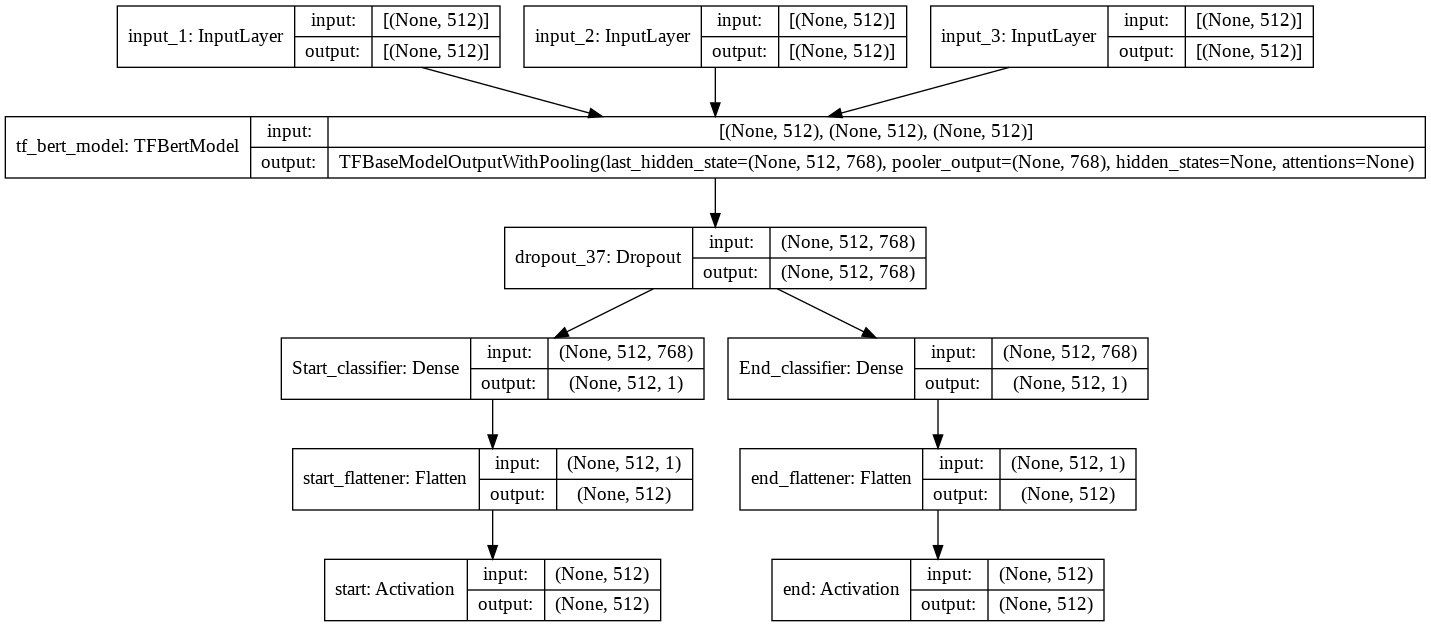

In [16]:
def build_model():

  # Define Input layers
  input_ids_layer = Input(shape = (512,), dtype='int64')
  attention_mask_layer = Input(shape = (512,), dtype='int64')
  token_ids_layer = Input(shape = (512,), dtype='int64')

  # Load Bert model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  
  bert_model.trainable = True
  
  # Initialize bert model
  bert = bert_model([input_ids_layer,
                    attention_mask_layer,
                    token_ids_layer],
                    return_dict = False,
                    output_attentions = False,
                    output_hidden_states = False
                    ).last_hidden_state
  
  # Dropout
  dropout = Dropout(0.2)(bert)

  # Classifiers
  start_classifier = Dense(units=1, name="Start_classifier")(dropout)
  end_classifier = Dense(units=1, name="End_classifier")(dropout)

  # Flatteners
  start_flat = Flatten(name="start_flattener")(start_classifier)
  end_flat = Flatten(name="end_flattener")(end_classifier)

  # Activations
  start_softmax = Activation(tf.keras.activations.softmax, name="start")(start_flat)
  end_softmax = Activation(tf.keras.activations.softmax, name="end")(end_flat)

  # Build model
  model = Model(inputs=[input_ids_layer, attention_mask_layer, token_ids_layer], 
                outputs=[start_softmax, end_softmax])
  
  model.summary()
  return model

model = build_model()
plot_model(model, show_shapes=True)

In [17]:
# Define model parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08
                                     #, clipnorm=1.0
                                     )
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

if LOAD_WEIGHTS:
  model.load_weights('/content/drive/MyDrive/SQUAD/weights.h5')

# Train

In [18]:
if TRAIN:

  for i in range(EPOCHS):
    # Fit model with train set
    model_fit = model.fit(x = [train['input_ids'][:TRAIN_LIMIT],
                              train['attention_mask'][:TRAIN_LIMIT],
                              train['token_type_ids'][:TRAIN_LIMIT]],
                          y = (np.array(train['start_idx'][:TRAIN_LIMIT], dtype=np.float32),
                              np.array(train['end_idx'][:TRAIN_LIMIT], dtype=np.float32)),
                              
                              batch_size = BATCH_SIZE,
                              epochs = 1, 
                              
                              validation_data=([val['input_ids'][:VAL_LIMIT],
                                                val['attention_mask'][:VAL_LIMIT],
                                                val['token_type_ids'][:VAL_LIMIT]],
                                                (np.array(val['start_idx'][:VAL_LIMIT], dtype=np.float32),
                                                np.array(val['end_idx'][:VAL_LIMIT], dtype=np.float32))
                                              )
                              )
      
    if SAVE_WEIGHTS:
      model.save_weights('/content/drive/MyDrive/SQUAD/weights.h5')

# Test

## Compute predictions

In [19]:
# Predict test set
pred = model.predict([test["input_ids"][:TEST_LIMIT], 
                      test["attention_mask"][:TEST_LIMIT], 
                      test["token_type_ids"][:TEST_LIMIT]],
                      verbose = 1)

pred_start_ids = np.argmax(pred[0], axis=-1)
pred_end_ids = np.argmax(pred[1], axis=-1)

551/551 [==============================] - 720s 1s/step


## Compute scores

In [20]:
start_acc =  accuracy_score(test['start_idx'][:TEST_LIMIT], pred_start_ids)
start_f1 = f1_score(test['start_idx'][:TEST_LIMIT], pred_start_ids, average="macro")
end_acc = accuracy_score(test['end_idx'][:TEST_LIMIT], pred_end_ids)
end_f1 = f1_score(test['end_idx'][:TEST_LIMIT], pred_end_ids, average="macro")

In [21]:
def most_similar_answer(context, answer):
  answer = answer.replace(" .", ".")
  answer = answer.replace(" ,", ",")
  answer = answer.replace(" ;", ";")
  answer = answer.replace(" :", ":")
  answer = answer.replace(" '", "'")
  answer = answer.replace(" %", "%")
  answer = answer.replace(" $", "$")

  answer_list = answer.split(" ")
  context_list = context.split(" ")

  for i, element in enumerate(context_list):
    lowered = []
    for token in context_list[i:i+len(answer_list)]:
      lowered.append(token.lower())

    if lowered == answer_list:
      return True, ' '.join(context_list[i:i+len(answer_list)])
  
  return False, answer

In [24]:
def get_text_from_token_ids(context, start_id, end_id):
  return tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(context[start_id:end_id+1]))

# Initialize variables
outputs_dict = {}     # output dictionary in requested format ('question_id': 'answer_text')
exact_match = 0       # exact match counter

for i, input_ids in enumerate(test['input_ids'][:TEST_LIMIT]):

  # Extract variables
  question_id = test['question_id'][i]
  question_text = test["question_text"][i]
  context = test_context_dict[test["context_id"][i]]
  true_start = test['start_idx'][i]
  true_end = test['end_idx'][i]
  pred_start = pred_start_ids[i]
  pred_end = pred_end_ids[i]

  # Extract answers
  true_answer = test['answer_text'][i]
  predicted_answer = get_text_from_token_ids(input_ids, pred_start, pred_end)

  # Convert answer (if possible)
  convert_flag, converted_answer = most_similar_answer(context, predicted_answer)

  # Count exact matches
  if pred_start == true_start and pred_end == true_end:
    exact_match += 1
    
  # If answer not found
  if pred_start == 0 and pred_end == 0:
    converted_answer = ""

  # Write answer dictionary
  outputs_dict[question_id] = converted_answer

  # Print some examples
  if i % 100 == 0:
    print("\n\nQuestion: \n", question_text)
    print("Context: \n", context)

    print(f"True answer: \n\tids {(true_start, true_end)}\t\ttext: {true_answer}")
    print(f"Our answer: \n\tids {(pred_start, pred_end)}\t\ttext: {converted_answer}")
    
    if convert_flag:
      print("(was converted)")

    print("\n", "-"*50)



Question: 
 What profession is more likely to want to repeal DST: farmers or shopkeepers?
Context: 
 Opponents argue that actual energy savings are inconclusive, that DST increases health risks such as heart attack, that DST can disrupt morning activities, and that the act of changing clocks twice a year is economically and socially disruptive and cancels out any benefit. Farmers have tended to oppose DST.
True answer: 
	ids (444, 444)		text: Farmers
Our answer: 
	ids (444, 447)		text: farmers or shopkeepers

 --------------------------------------------------


Question: 
 What industry is Broadway associated with?
Context: 
 Despite New York's heavy reliance on its vast public transit system, streets are a defining feature of the city. Manhattan's street grid plan greatly influenced the city's physical development. Several of the city's streets and avenues, like Broadway, Wall Street, Madison Avenue, and Seventh Avenue are also used as metonyms for national industries there: the th

## Save results to Drive

In [25]:
time = datetime.now().strftime("%d-%m-%Y_%H:%M")

with open(f"/content/drive/MyDrive/SQUAD/Results/results_{time}.txt", "w") as f:

  f.write(f"TEST start accuracy: {start_acc}")
  f.write(f"\nTEST start f1-score: {start_f1}")

  f.write(f"\n\nTEST end accuracy: {end_acc}")
  f.write(f"\nTEST end f1-score: {end_f1}")

  f.write("\n\nTest exact matches: {}/{} ({:.2f}%)".format(exact_match, len(test['input_ids'][:TEST_LIMIT]), exact_match/len(test['input_ids'][:TEST_LIMIT])*100))

with open(f"/content/drive/MyDrive/SQUAD/Outputs/outputs_{time}.json", 'w') as fp:
    json.dump(outputs_dict, fp)

## Load results from Drive

In [26]:
with open(f"/content/drive/MyDrive/SQUAD/Results/results_{time}.txt", "r") as f:
  for line in f.readlines():
    print(line, end="")

with open(f"/content/drive/MyDrive/SQUAD/Outputs/outputs_{time}.json", "r") as f:
  outputs_dict = json.load(f)

TEST start accuracy: 0.6476460578559274
TEST start f1-score: 0.5715959136930618

TEST end accuracy: 0.6960294951786727
TEST end f1-score: 0.6249357792514222

Test exact matches: 9644/17630 (54.70%)

In [27]:
for key in outputs_dict.keys():
  print(f"{key}: {outputs_dict[key]}")

Output streaming troncato alle ultime 5000 righe.
570c488cb3d812140066d079: the late 1890s
5725e38bec44d21400f3d70d: Arsaces
5728d3294b864d1900164ee2: bachelor' s, master' s, and doctoral studies
572f8b45b2c2fd14005681d6: drives
56f7fe64aef2371900625d4e: humble
57304a87069b531400831ff9: the elegant palatine hill
56e72ba200c9c71400d76edb: second world war
56d101b117492d1400aab713: roosevelt island
57085206efce8f15003a7da2: Pitch
570a0f9d4103511400d59549: the fourth league
5710088bb654c5140001f76e: june 2001
571b5e2e9499d21900609c6f: asphaltum
573005e3a23a5019007fcc62: gave the tribunes a great deal of power
56de2b36cffd8e1900b4b603: 2011
5735fcb96c16ec1900b928cb: pope innocent iii
5728be814b864d1900164d40: the baltic council is the joint forum of the interparliamentary baltic assembly ( ba )
56e1657ee3433e1400422e7f: Republic Studios
56df76c85ca0a614008f9ac5: 1876
56de92c1cffd8e1900b4b9fd: consciousness
572fffe804bcaa1900d76ffb: one of the top 10 private research universities in the nat